In [59]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, json, logging
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from pathlib import Path
from util import config_logger
from util import openH5File, encode4h5, parse_suffix, config_logger


import numpy as np, pandas as pd, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP
import anndata as ad

import scanpy as sc

import torch
torch.set_num_threads(16)
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

from matplotlib import pyplot as plt
from load_data import load_expression, load_edges, load_genelist

import seaborn as sns
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

logger = config_logger(logging.getLogger(__name__))

In [60]:
def center_scale(arr):
    return (arr - arr.mean(axis=0)) / arr.std(axis=0)

## Read in murine data

In [61]:
df_clean = pd.read_csv('../../../st_projects/spatial_clust/data/tonsil/processed_data/meta_data/features_and_metadata.csv', index_col = 0)

In [62]:
df_clean

,cellLabelInImage,cellSize,HOECHST1,CD38,CD19,CD31,Vimentin,CD22,Ki67,CD8,...,CD104,CD273,FAPalpha,Ecadherin,PointNum,cluster.term,centroid_x,centroid_y,X_view,Y_view
1,1,45,7577.133333,0.042709,0.126471,0.013933,0.167720,0.378127,0.022083,0.070043,...,0.016006,0.021456,0.000000,0.294373,reg001_X02_Y05_Z09,B-CD22-CD40,1.822222,797.333333,2,5
2,2,67,5689.014925,0.411814,0.274831,0.078204,0.242115,0.732288,0.032531,0.129478,...,0.046936,0.242958,0.195214,0.518544,reg001_X02_Y05_Z09,B-CD22-CD40,2.149254,1335.044776,2,5
3,3,54,2918.629630,0.181537,0.049070,0.107920,0.256650,0.136265,0.046391,0.277171,...,0.066806,0.087647,0.168854,0.798743,reg001_X02_Y05_Z09,Fibro/Epi,1.685185,56.740741,2,5
5,5,40,3712.550000,0.105352,0.355472,0.123463,1.000000,0.244163,0.039550,0.052428,...,0.139895,0.123207,0.769419,0.384925,reg001_X02_Y05_Z09,B-CD22-CD40,1.825000,652.025000,2,5
6,6,65,9896.523077,0.109826,0.489116,0.077057,0.566872,1.000000,0.021881,0.078402,...,0.022732,0.033790,0.159045,0.220309,reg001_X02_Y05_Z09,B-CD22-CD40,2.246154,683.676923,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375978,3513,70,4149.171000,0.000000,0.026146,0.001722,0.611818,0.000000,0.021935,0.000000,...,0.074332,0.171887,0.302279,0.128266,reg001_X10_Y15_Z04,CD4 T,11085.185714,11493.671429,10,15
375979,3514,51,1196.824000,0.750703,0.043029,0.577087,0.154900,0.031831,0.030165,0.048098,...,0.149224,1.000000,1.000000,0.720069,reg001_X10_Y15_Z04,Fibro/Epi,11085.215686,11664.666667,10,15
375980,3515,38,2536.632000,0.000000,0.130797,0.000000,0.000000,0.000000,0.016872,0.000000,...,0.032043,0.000000,0.000000,0.000000,reg001_X10_Y15_Z04,Plasma,11085.631579,11691.500000,10,15
375981,3516,34,4547.529000,0.404353,0.260548,0.073022,0.436796,0.641083,0.030313,0.014269,...,0.076619,0.205713,0.219130,0.188265,reg001_X10_Y15_Z04,B-CD22-CD40,11085.647059,11136.441176,10,15


In [63]:
xrange = [ 4, 5, 6, 7, 8]
yrange = [8, 9, 10, 11, 12, 13]
df_clean = df_clean[df_clean["X_view"].isin(xrange) & df_clean["Y_view"].isin(yrange)]
df_clean.shape

(102574, 55)

In [64]:
feature_names = ['HOECHST1', 'CD38', 'CD19', 'CD31',
        'Vimentin', 'CD22', 'Ki67', 'CD8', 'CD90', 'CD123', 'CD15', 'CD3',
        'CD152', 'CD21', 'cytokeratin', 'CD2', 'CD66', 'collagen IV', 'CD81',
        'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278', 'podoplanin', 'CD45RA', 'CD34',
        'CD54', 'CD9', 'IGM', 'CD117', 'CD56', 'CD279', 'CD45', 'CD49f', 'CD5',
        'CD16', 'CD63', 'CD11b', 'CD1c', 'CD40', 'CD274', 'CD27', 'CD104',
        'CD273', 'FAPalpha', 'Ecadherin'
]
df = df_clean
print('Constructing graph and obtaining initial clustering using features...')
features = df[feature_names].to_numpy()
features = center_scale(features)

features =(features-features.min(axis = 0))/(features.max(axis = 0)-features.min(axis = 0))

# expr_processed = expression / expression.sum(1, keepdims=True) * 1e4
# expr_processed = np.log1p(expr_processed)

Constructing graph and obtaining initial clustering using features...


In [65]:
features.shape

(102574, 47)

In [66]:
save_path = "../data/codex_tonsil/files"
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [67]:
np.savetxt(os.path.join(save_path, "expression_0_minmax.txt"), features ) 

In [68]:
features.shape

(102574, 47)

In [69]:
locations = df[['centroid_x', 'centroid_y']].to_numpy()
adata = ad.AnnData(features, dtype=np.float32)

In [70]:
adata.obsm["spatial"] = locations

In [71]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=None, use_rep='spatial')

In [72]:
adata

AnnData object with n_obs × n_vars = 102574 × 47
    uns: 'neighbors'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

In [73]:
rows, cols = adata.obsp['connectivities'].nonzero()

In [76]:
edges = np.array([rows, cols]).T

In [77]:
#np.savetxt(os.path.join(save_path, "neighborhood_0.txt"), edges) 
file = open(os.path.join(save_path, "neighborhood_0.txt"),'w')
for i in range(rows.shape[0]):
    file.write(str(rows[i])+" "+str(cols[i])+"\n")
file.close()

In [78]:
feature_names[17] = 'collagen_IV'
file = open(os.path.join(save_path, "genes_0_minmax.txt"),'w')
for item in feature_names:
    file.write(item+"\n")
file.close()

In [80]:
file = open(os.path.join(save_path, "celltypes_0.txt"),'w')
for i in range(df.shape[0]):
    file.write(df['cluster.term'].iloc[i] + "\n")
file.close()

## Run SpiceMix

In [82]:
# -- specify device
context = dict(device='cpu', dtype=torch.float64)
# context = dict(device='cpu', dtype=torch.float64)
context_Y = context
# -- specify dataset
path2dataset = Path('../data/codex_tonsil/')
repli_list = ['0']

In [83]:
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

np.random.seed(0)

K, num_pcs, n_neighbors, res_lo, res_hi = 20, 20, 15, .5, 2.

path2result = path2dataset / 'results' / 'SpiceMix.h5'
os.makedirs(path2result.parent, exist_ok=True)
if os.path.exists(path2result):
    os.remove(path2result)
    
obj = SpiceMix(
    K=K,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    path2result=path2result,
)

obj.load_dataset(path2dataset, expression_suffix="minmax")


2023-06-13 12:35:39:INFO:result file = ../data/codex_tonsil/results/SpiceMix.h5
2023-06-13 12:35:41:INFO:Loaded 102574 cells and 47 genes from ../data/codex_tonsil/files/expression_0_minmax.txt
2023-06-13 12:35:41:INFO:Loaded 47 genes from ../data/codex_tonsil/files/genes_0_minmax.txt
2023-06-13 12:35:47:WARNING:Detected 785127 duplicate edge(s) from 1570254 loaded edges. Duplicate edges are discarded.
2023-06-13 12:35:47:INFO:Loaded 785127 edges from ../data/codex_tonsil/files/neighborhood_0.txt


In [ ]:
for iiter in range(1, 200):
    logger.info(f'Iteration {iiter}')
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)

In [86]:
latent_states = [X.cpu().numpy() for X in obj.Xs]
latent_state_cat = np.concatenate(latent_states, axis=0)

/home/sheng/miniconda3/envs/SpiceMix/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


<AxesSubplot:title={'center':'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

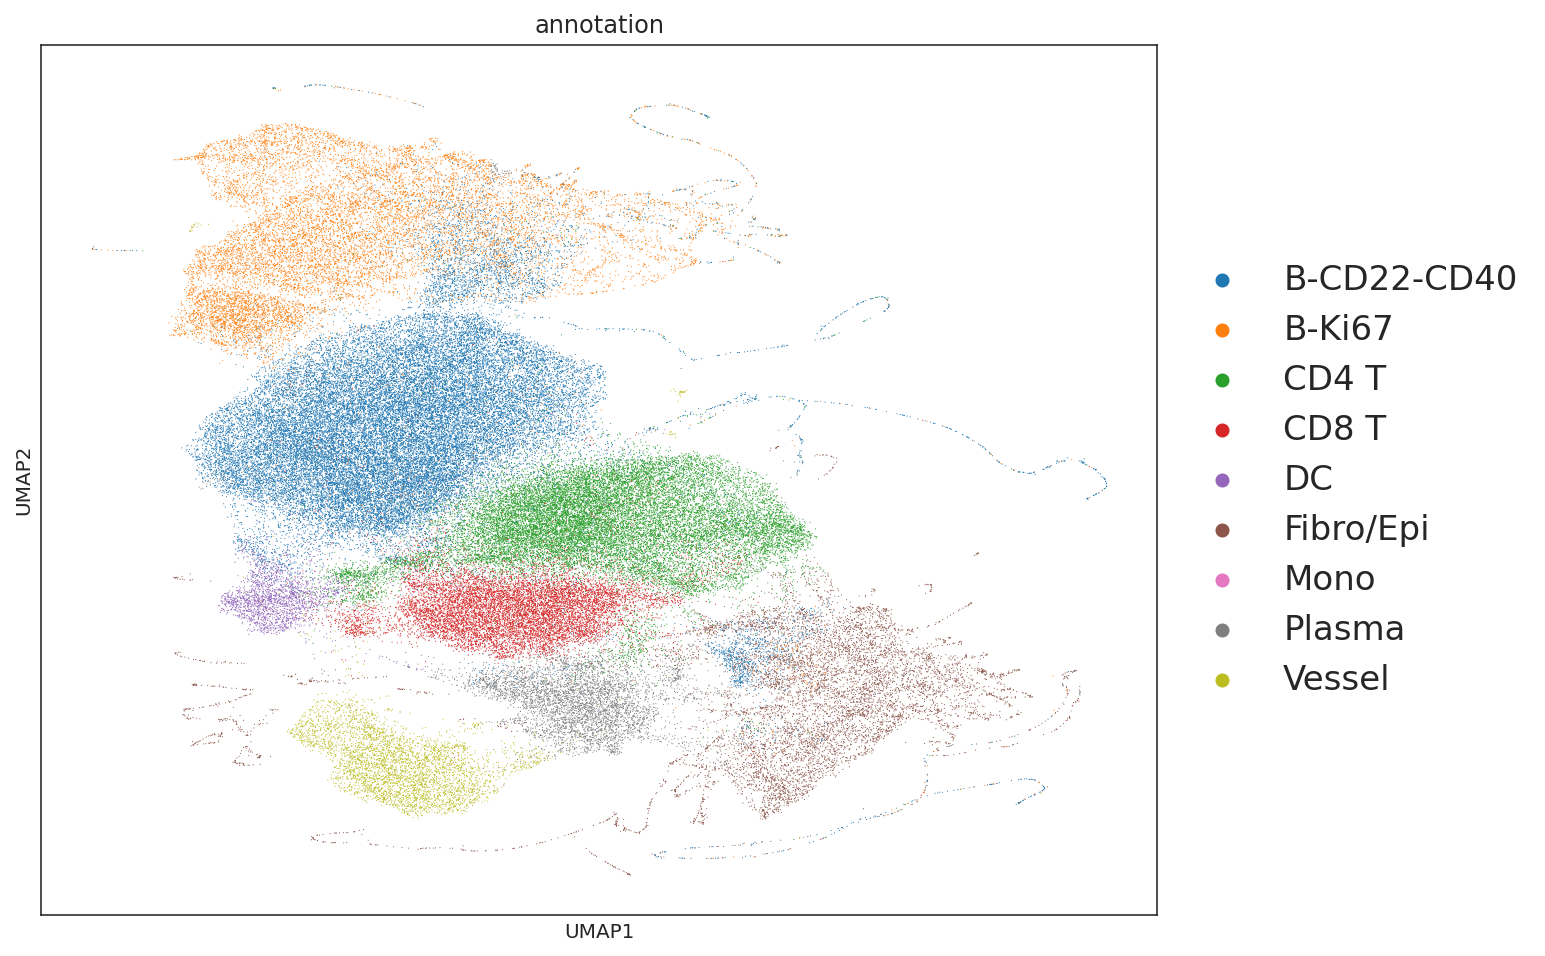

In [87]:
# full feature embeddings
feature_adata = ad.AnnData(latent_state_cat)
sc.pp.scale(feature_adata)
feature_adata.obs['annotation'] = list(df['cluster.term'])
sc.tl.pca(feature_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(feature_adata, n_neighbors=10)
sc.tl.umap(feature_adata)
plt.rcParams["figure.figsize"] = (10,8)
sc.pl.umap(feature_adata, color='annotation', legend_fontsize=17, show=False)

In [88]:
latent_state_cat.mean(axis = 0)

array([1.5638586 , 1.18609176, 1.76026879, 1.04280744, 0.69307439,
       1.25587427, 2.35790052, 1.58701301, 0.43092087, 0.81620874,
       0.74937148, 0.84409919, 1.61709494, 1.02592968, 0.9257904 ,
       0.44874659, 0.91308112, 0.29835205, 0.51959972, 0.47320394])

In [89]:
np.save(os.path.join(save_path, f"spicemix_k{K}_minmax.npy"), latent_state_cat) 